In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2
import os
import librosa
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb

In [5]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.4 MB 656.4 kB/s eta 0:00:03
   - -------------------------------------- 0.1/1.4 MB 653.6 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 722.1 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.4 MB 706.2 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.4 MB 831.5 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.4 MB 765.3 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.4 MB 758.5 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.4 MB 791.9 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.4 MB 800.8 kB/s eta 0:00:02
   ---------- ----------------------------- 0.4/1.4 MB 836.4 kB/s eta 0:00:02
   -


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:

path_to_wav_files = '\\Users\\Alex\\Downloads\\archive\\free-spoken-digit-dataset-master\\recordings'
labels=np.array([])
audio_arrays=[]
i=1
for filename in os.listdir(path_to_wav_files):
    if filename.endswith(".wav"):
        file_path = os.path.join(path_to_wav_files, filename)
        audio, sr = librosa.load(file_path)
        if(i):
            time = np.arange(len(audio)) / sr  # создаем массив времени
            i=0
        audio_arrays.append(audio)
        label = filename.split("_")[0]
        labels=np.append(labels,label)

#print(time[1]) #частота дискретизации в Hz

df=pd.DataFrame({'audio':audio_arrays,'label':labels})

from sklearn.model_selection import train_test_split

df0=df[(df['label']=='0') | (df['label']=='1')]
df0.shape
df0=df0.reset_index(drop=True)

df0x, df0x_test, y0_train, y0_test = train_test_split(df0['audio'], df0['label'], test_size=0.2, shuffle=True)
#df0x_test=df0x_test[:20]
#y0_test=y0_test[:20]
print(df0x)
print(y0_train)

443    [-0.0002805575, -0.00025009474, 3.6174868e-05,...
478    [-0.011637319, -0.0076257177, -0.0016724988, -...
89     [-0.009149417, -0.012001386, -0.011685444, -0....
164    [-0.0064187893, -0.008576229, -0.008842887, -0...
456    [0.008878557, 0.010662455, 0.008094132, 0.0058...
                             ...                        
94     [-0.008699016, -0.011244009, -0.010691646, -0....
288    [0.00020029128, 0.0002565764, 0.00022449956, 0...
32     [-0.016380444, -0.01763609, -0.0112183, -0.004...
413    [4.0234965e-05, 0.000101468635, 0.0001514533, ...
453    [-0.009525584, -0.0148654515, -0.015377706, -0...
Name: audio, Length: 480, dtype: object
443    1
478    1
89     0
164    0
456    1
      ..
94     0
288    0
32     0
413    1
453    1
Name: label, Length: 480, dtype: object


In [17]:
import warnings
warnings.filterwarnings("ignore")

train fifnishs
start clf
[LightGBM] [Info] Number of positive: 236, number of negative: 244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20125
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491667 -> initscore=-0.033336
[LightGBM] [Info] Start training from score -0.033336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

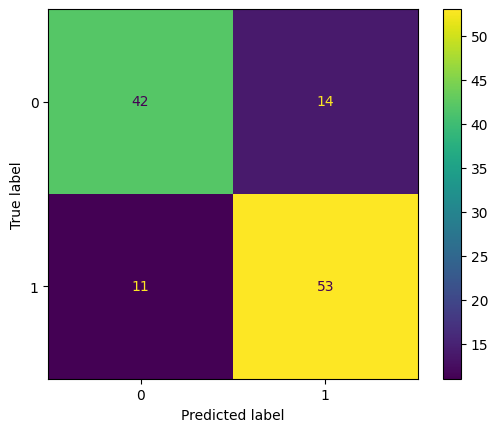

In [25]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
dtd=time[1]
N=125
df0x=df0x.reset_index(drop=True)
df0x_test=df0x_test.reset_index(drop=True)
y0_train=np.array(y0_train)
y0_test=np.array(y0_test)
data_train=np.zeros((df0x.shape[0],N))
data_test=np.zeros((df0x_test.shape[0],N))
for i in range(df0x.shape[0]):
    X = np.linspace(0,df0x[i].shape[0]*dtd,df0x[i].shape[0])
    X= X.astype('double')
    Y_fft = fft(df0x[i])
    freq = fftfreq(len(X), d=dtd)
    peaks, _ = find_peaks(np.abs(Y_fft), height=0.01)
    peaks=peaks[freq[peaks]>=0]
    peaks.sort()
    peaks=peaks[::-1]
    feature=peaks[:N]
    frequencies = freq[feature]
    data_train[i]=frequencies
print('train fifnishs')

for i in range(df0x_test.shape[0]):
    X = np.linspace(0,len(df0x_test[i])*dtd,len(df0x_test[i]))
    X= X.astype('double')
    Y_fft = fft(df0x_test[i])
    freq = fftfreq(len(X), d=dtd)
    peaks, _ = find_peaks(np.abs(Y_fft), height=0.01)
    peaks=peaks[freq[peaks]>=0]
    peaks.sort()
    peaks=peaks[::-1]
    feature=peaks[:N]
    frequencies = freq[feature]
    data_test[i]=frequencies

print('start clf')
#amplitudes = 2*np.abs(Y_fft[peaks]) / len(X)
clf=lgb.LGBMClassifier()#**params
clf.fit(data_train,y0_train.astype(float))
y_tr=clf.predict(data_train)
y_pred=clf.predict(data_test)
acc = accuracy_score(y0_train.astype(float), y_tr)
print(f"Accuracy: {acc}")
acc = accuracy_score(y0_test.astype(float), y_pred)
print(f"Accuracy: {acc}")
cm = confusion_matrix(y0_test.astype(float), y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [22]:
dtd=time[1]*b2.second
vt = -20*b2.mV
vr = -20*b2.mV

def create_input(Y):
  eqs1 = '''
  dx/dt = b*x - w*y : 1
  dy/dt = w*x + b*y + I_input(t) : 1
  b: Hz
  w: Hz
  val: Hz
  '''
  N=20
  I_input = b2.TimedArray(Y*b2.Hz,dt = dtd) 
  G = b2.NeuronGroup(N, eqs1, threshold = 'x > 0.02', reset='v = vr', method = 'euler', namespace={'I_input': I_input})
  G.add_attribute('I_input')
  G.b = -1*b2.Hz
  mon = b2.StateMonitor(G, ['x', 'y'], record=True, dt = dtd)
  freaqun=np.linspace(20,8000,num=N)
  #freaqun = np.array([20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480, 500,520,540,560,580,600,620,640,660,680,700,800,900, 1000,1500, 2000,3000, 5000, 8000])
  G.w =freaqun*1/b2.second 
  s_mon_inp = b2.SpikeMonitor(G)
  return G, s_mon_inp,mon
    
def evaluate(X):
  img_rates = np.zeros((len(X), len(input_layer)))
  T_show = 20*b2.ms
  T_rest = 5*b2.ms
  rate_mon = b2.SpikeMonitor(input_layer)
  prev_count = np.zeros((len(input_layer),))
  for i_img, img in enumerate(X):
    input_layer.I_input=b2.TimedArray(img.astype(np.float64)*b2.Hz,dt = dtd)
    b2.run(T_show, report=None)
    img_rates[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_rates[i_img,:]
    input_layer.I_input=b2.TimedArray(np.zeros(len(img)).astype(np.float64)*b2.Hz,dt = dtd)
    b2.run(T_rest, report=None)
  return img_rates

def evaluate2(X):
  img_rates = np.zeros((len(X), len(input_layer)))
  T_show = 20*b2.ms
  T_rest = 5*b2.ms
  rate_mon = b2.SpikeMonitor(input_layer)
  prev_count = np.zeros((len(input_layer),))
  for i_img, img in enumerate(X):
    input_layer.I_input=b2.TimedArray(img.astype(np.float64)*b2.Hz,dt = dtd)
    b2.run(T_show, report=None)
    img_rates[i_img,:] = np.array(rate_mon.count-prev_count)
    #каждую единицу времени записывать в массив номер наиболее активного нейрона
    prev_count += img_rates[i_img,:]
    input_layer.I_input=b2.TimedArray(np.zeros(len(img)).astype(np.float64)*b2.Hz,dt = dtd)
    b2.run(T_rest, report=None)
  return img_rates

b2.start_scope()
input_layer, mon_input,mons = create_input(df0['audio'][0])
b2.run(0*b2.ms)
b2.store() 
b2.restore()
train_rates = evaluate(df0x)
print(train_rates.shape)
print(train_rates)
test_rates = evaluate(df0x_test)

WARNING    'I' is an internal variable of group 'neurongroup', but also exists in the group-specific namespace with the value <Function>. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


(480, 30)
[[200. 200. 200. ... 200. 200. 200.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 ...
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 240, number of negative: 240
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirem

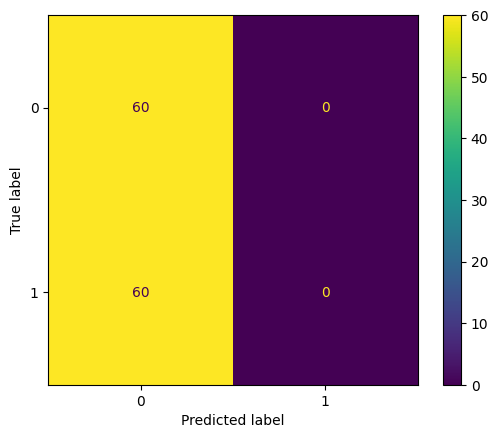

In [20]:
from sklearn.decomposition import PCA
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 35,
    'max_depth': 5,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 0.001,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}
#pca=PCA(40)
#x=pca.fit_transform(train_rates)
#x2=pca.transform(test_rates)
clf=lgb.LGBMClassifier()#**params
clf.fit(train_rates,y0_train.astype(float))
y_tr=clf.predict(train_rates)
y_pred=clf.predict(test_rates)
acc = accuracy_score(y0_train.astype(float), y_tr)
print(f"Accuracy: {acc}")
acc = accuracy_score(y0_test.astype(float), y_pred)
print(f"Accuracy: {acc}")
cm = confusion_matrix(y0_test.astype(float), y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [21]:
train_rates[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\Alex\AppData\Local\Temp\ipykernel_13516\2220716793.py', line 15, in create_input
    G = b2.NeuronGroup(N, eqs1, threshold = 'y > 0.02', reset='v = vr', method = 'euler', namespace={'I_input': I_input}) [brian2.core.base.unused_brian_object]


Text(0, 0.5, 'Input neuron')

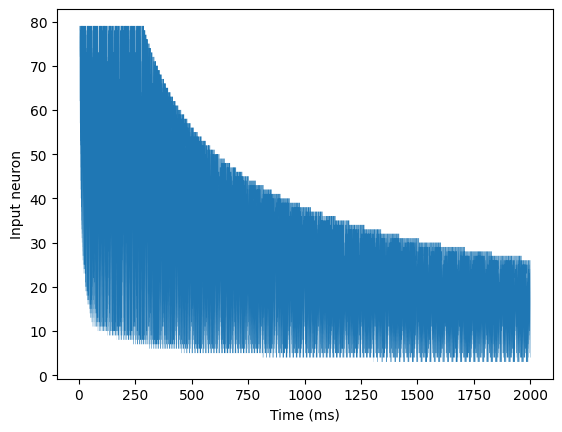

In [58]:
plt.plot(mon_input.t/b2.ms, mon_input.i, linewidth=0.05)
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron')